In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dayagan100","key":"6767a772b005bb2f1ac1d7d7cedad2ac"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d alessiocorrado99/animals10

 99% 577M/586M [00:15<00:00, 31.0MB/s]
100% 586M/586M [00:15<00:00, 39.9MB/s]


In [5]:
zf = '/content/animals10.zip'
zip_ref = zipfile.ZipFile(zf, 'r')
zip_ref.extractall('/content/animals')
zip_ref.close()

In [6]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "animals/raw-img",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "animals/raw-img",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 26179 files belonging to 10 classes.
Using 20944 files for training.
Found 26179 files belonging to 10 classes.
Using 5235 files for validation.


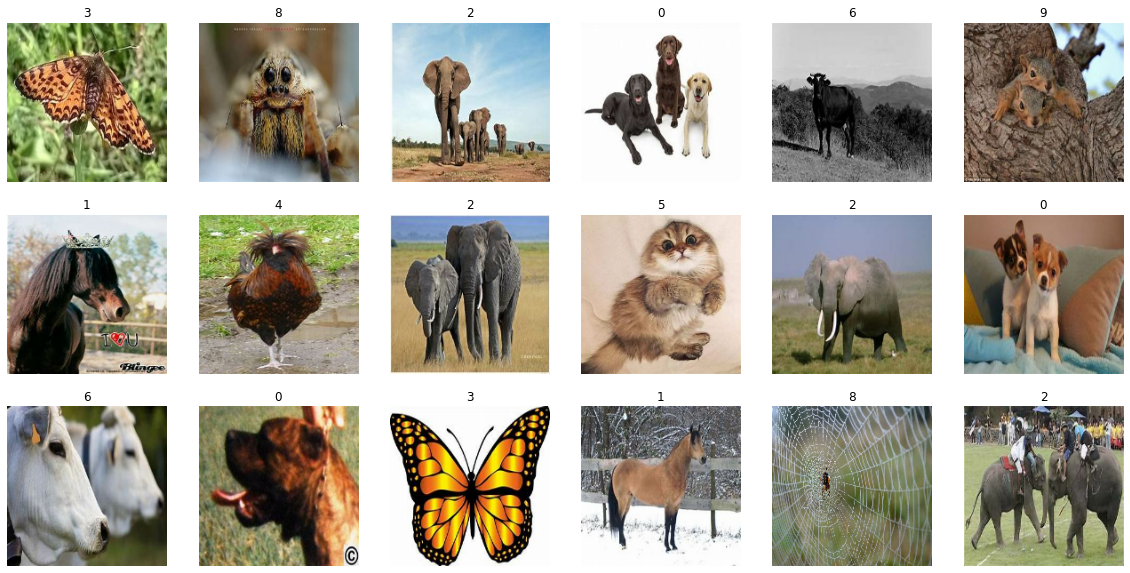

In [ ]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
  for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

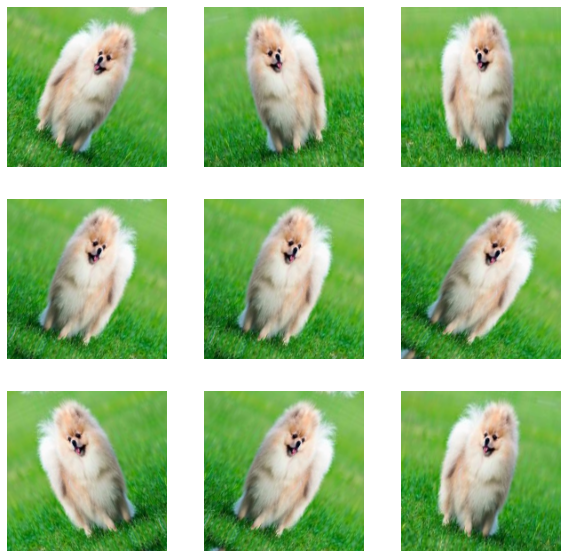

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [8]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

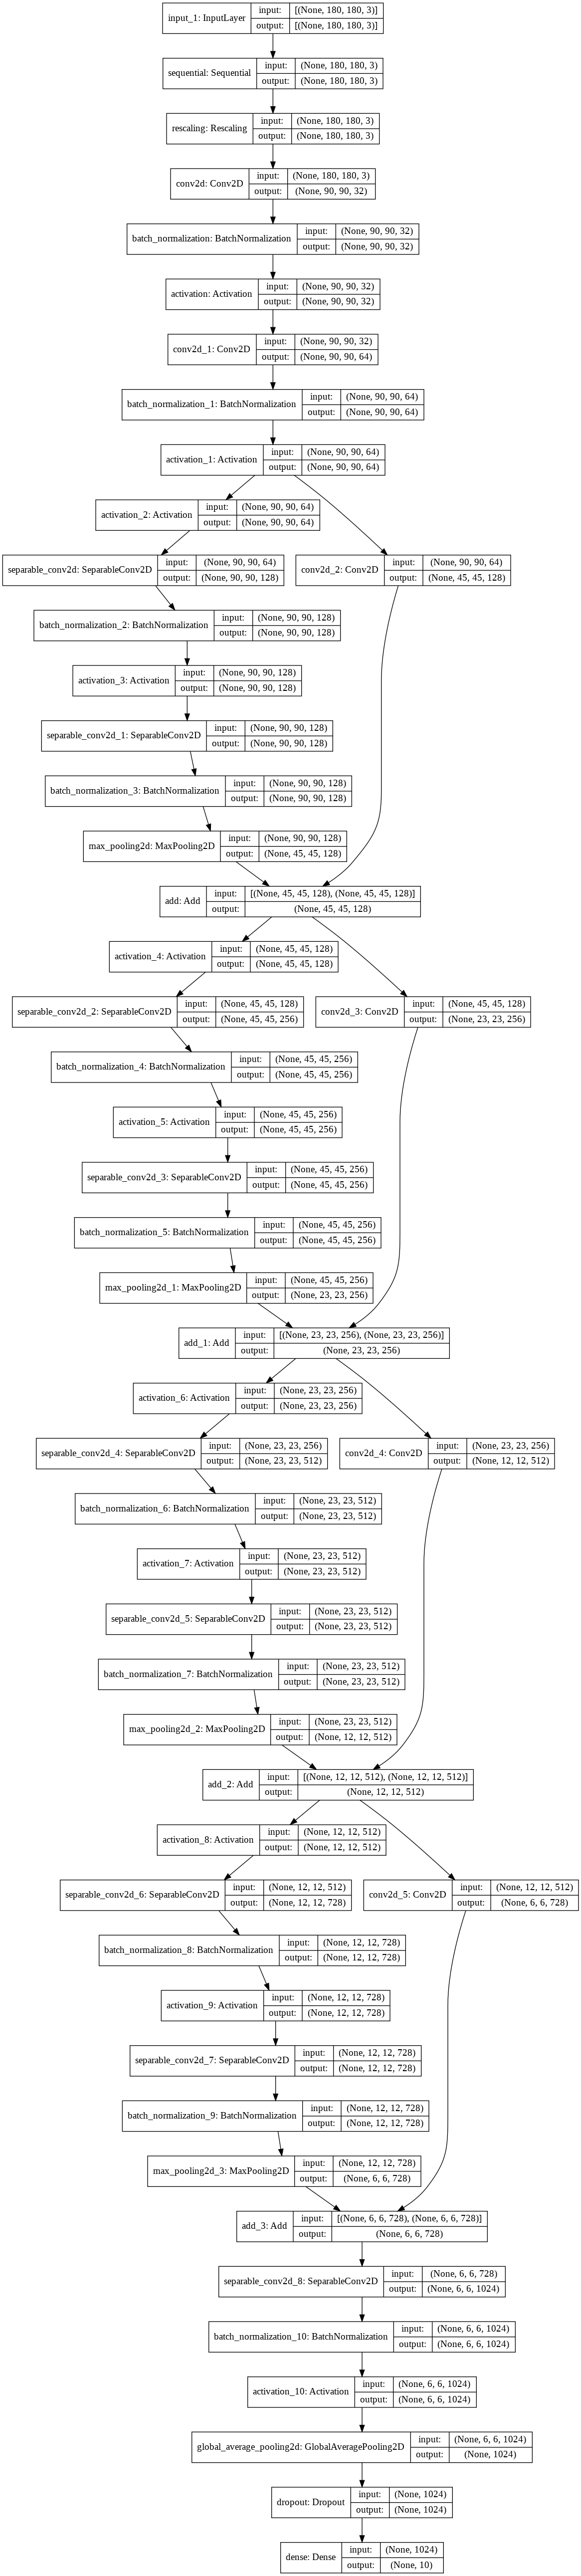

In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=10)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
655/655 [==============================] - 127s 191ms/step - loss: 0.5913 - sparse_categorical_accuracy: 0.8048 - val_loss: 1.2246 - val_sparse_categorical_accuracy: 0.6246
Epoch 2/10
655/655 [==============================] - 127s 193ms/step - loss: 0.5317 - sparse_categorical_accuracy: 0.8252 - val_loss: 0.6043 - val_sparse_categorical_accuracy: 0.8082
Epoch 3/10
655/655 [==============================] - 130s 198ms/step - loss: 0.5027 - sparse_categorical_accuracy: 0.8320 - val_loss: 0.7826 - val_sparse_categorical_accuracy: 0.7484
Epoch 4/10
655/655 [==============================] - 131s 199ms/step - loss: 0.4883 - sparse_categorical_accuracy: 0.8400 - val_loss: 1.1593 - val_sparse_categorical_accuracy: 0.6521
Epoch 5/10
655/655 [==============================] - 134s 203ms/step - loss: 0.4560 - sparse_categorical_accuracy: 0.8494 - val_loss: 1.1004 - val_sparse_categorical_accuracy: 0.7032
Epoch 6/10
655/655 [==============================] - 125s 190ms/step - loss: 0.

In [14]:
def plot(losses, accuracies, subplot_title):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,4))

  ax1.plot(losses)
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title(subplot_title[0])

  ax2.plot(accuracies)
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title(subplot_title[1])

  plt.show()

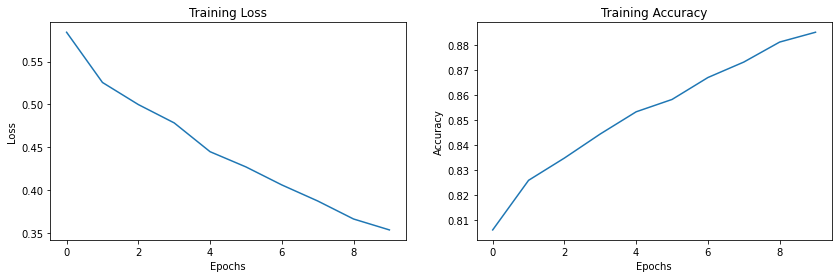

In [15]:
# Training
plot(history.history['loss'], 
     history.history['sparse_categorical_accuracy'], 
     subplot_title=['Training Loss', 'Training Accuracy']
    )

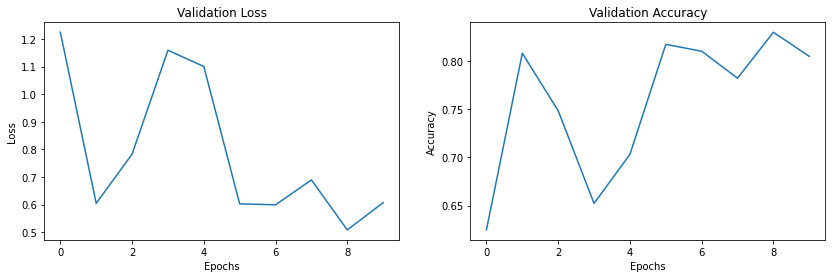

In [16]:
# Validation
plot(history.history['val_loss'], 
     history.history['val_sparse_categorical_accuracy'], 
     subplot_title=['Validation Loss', 'Validation Accuracy']
    )